# Data Preprocessing

In [1]:
# Libraries
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import soundfile
import include 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

## Basic Setup

In [2]:
# Diretory
os.chdir(r'Downloads')

In [3]:
# Paths
urbansound8_path = os.path.abspath('./UrbanSound8K' )
metadata_path = os.path.join(urbansound8_path, 'metadata/UrbanSound8K.csv')
metadata = pd.read_csv(metadata_path)
audio_path = os.path.join(urbansound8_path, 'audio')
processed_audio_path = os.path.join(urbansound8_path, 'processed_audio')
# Check if the folder exists, and if not, create it
if not os.path.exists(processed_audio_path):
    os.makedirs(processed_audio_path)

In [6]:
for fold in range(1, 11):
    # Create the new 10 folders on processed_audio_path
    os.makedirs(os.path.join(processed_audio_path, 'fold' + str(fold)), exist_ok=True)

In [4]:
# Variables
duration = 4
sample_rate = 44100
length = duration*sample_rate
hop_length=round(sample_rate*0.0125) # number of samples between successive frames
win_length=round(sample_rate*0.023) # number of samples in each frame for the STFT

## Pre-processing the audios

Our objective on pre-processing the audios is to uniform and normalize the netword input.
To do that, for each audio we:
- turned it into a 4 seconds audio;
- normalized it to a [-1, 1] range

In [12]:
def normalize_audio(audio):
    # Normalize the audio to the following range: [-1, 1]
    audio = librosa.util.normalize(audio)
    return audio

In [13]:
def preprocess_audio(file, length, sample_rate):
    # Objective: turn all the files into 4-sec audios

    audio, sr = librosa.load(file, sr=sample_rate)
    audio = normalize_audio(audio)

    if len(audio) > length:
        audio = audio[:length]
        
    elif len(audio) < length:
        padding = length - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')

    return audio, sample_rate

In [10]:
for index, row in metadata.iterrows():
    # Construct the file path for the original audio
    file = os.path.join(audio_path, 'fold' + str(row['fold']), row['slice_file_name'])

    if os.path.exists(file):
        # Construct the file path for saving the processed audio
        audio, sr = preprocess_audio(file, length, sample_rate)
        processed_file_path = os.path.join(processed_audio_path, 'fold' + str(row['fold']), row['slice_file_name'])
        
        # Save the processed audio in .wav format using soundfile
        soundfile.write(processed_file_path.replace('.npy', '.wav'), audio, sr)
    else:
        print(f"File not found: {file}")


## Testing an example

Here we are going to see the spectrogram of an audio based on:
- mel-frequency cepstral coefficients (MFCC);
- mel-scalled;

In [14]:
# Get a random file
row = metadata.sample(3)
file_path = processed_audio_path + '\\fold'+ str(row.iloc[0,5]) + '\\' + str(row.iloc[0,0])

# Load audio file
audio_data, sr = librosa.load(file_path)

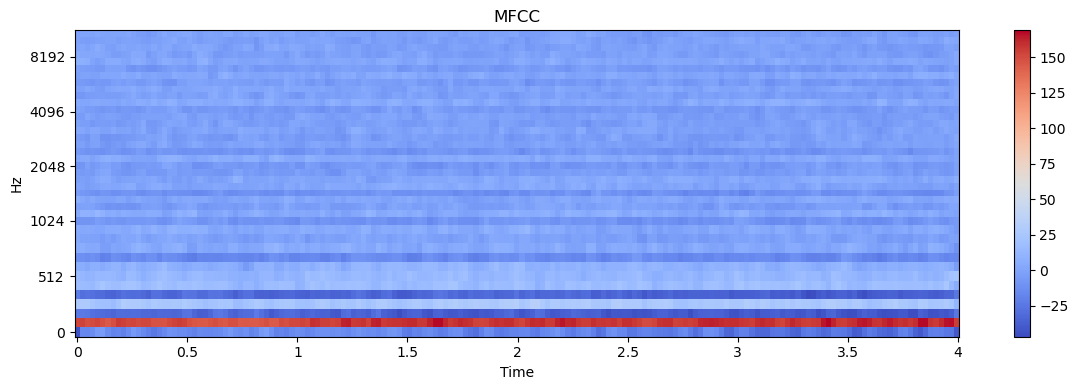

In [53]:
# Generate MFCC coefficients
mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)

# Plot spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

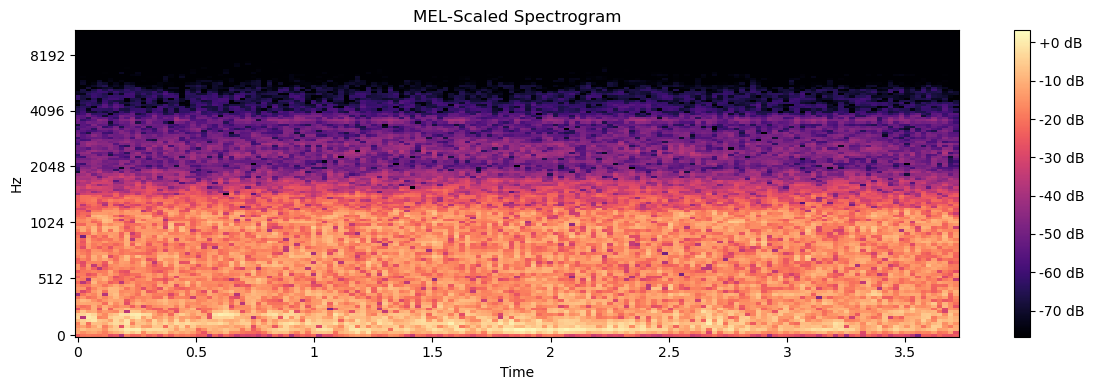

In [55]:
n_mels = 128
n_fft = 2048

stft = librosa.core.stft(audio_data, n_fft=n_fft, hop_length=hop_length)

# Generate mel scaled spectrogram
# mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
mel = librosa.feature.melspectrogram(S=stft, n_mels=n_mels)

# Convert sound intensity to log amplitude:
mel_db = librosa.amplitude_to_db(abs(mel))

# Normalize between -1 and 1
# normalized_mel = librosa.util.normalize(mel_db)

# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_db, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');
plt.title('MEL-Scaled Spectrogram')
plt.tight_layout()
plt.show()

## Feature extraction

Now we are going to extract the features of the dataset via 2 methods we already said before:
- mel-frequency cepstral coefficients (MFCC);
- mel-scalled;

MFCC features will be used for the multilayer perceptron (MLP).                              
Mel-scalled spectrograms will be the input for the CNN-based classifier.

### With MFCC

In [23]:
# Iterate through all audio files and extract MFCC
# mfcc -> mel-frequency cepstral coefficients
features_mfcc = []
labels_mfcc = [] # to list the classes on the df we will create later
folds_mfcc = [] # to list the folds on the df we will create later
audios_mfcc = [] # to list the audios on the df we will create later
frames_max = 0
counter = 0
total_samples = len(metadata)
n_mfcc = 40

for index, row in metadata.iterrows():
    # getting the path
    file_path = os.path.join(os.path.abspath(processed_audio_path), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    class_label = row["class"]
    fold_value = row["fold"]
    audio_name = row["slice_file_name"]

    # extract the MFCCs
    audio_data, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    
    # save current frame count
    num_frames = mfccs.shape[1]
    
    # add row
    features_mfcc.append(mfccs)
    labels_mfcc.append(class_label)
    folds_mfcc.append(fold_value)
    audios_mfcc.append(audio_name)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

    # Notify update every N files
    if (counter == 250):
        print("Status: {}/{}".format(index+1, total_samples))
        counter = 0

    counter += 1
    
print("Finished: {}/{}".format(index, total_samples))

Status: 251/8732
Status: 501/8732
Status: 751/8732
Status: 1001/8732
Status: 1251/8732
Status: 1501/8732
Status: 1751/8732
Status: 2001/8732
Status: 2251/8732
Status: 2501/8732
Status: 2751/8732
Status: 3001/8732
Status: 3251/8732
Status: 3501/8732
Status: 3751/8732
Status: 4001/8732
Status: 4251/8732
Status: 4501/8732
Status: 4751/8732
Status: 5001/8732
Status: 5251/8732
Status: 5501/8732
Status: 5751/8732
Status: 6001/8732
Status: 6251/8732
Status: 6501/8732
Status: 6751/8732
Status: 7001/8732
Status: 7251/8732
Status: 7501/8732
Status: 7751/8732
Status: 8001/8732
Status: 8251/8732
Status: 8501/8732
Finished: 8731/8732


In [24]:
# Add padding to features
padded_features_mfcc = []
for mfcc in features_mfcc:
    pad_width = frames_max - mfcc.shape[1]
    padded_mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    padded_features_mfcc.append(padded_mfcc)

# Convert features to a numpy array
features_array_mfcc = np.array(padded_features_mfcc)

In [25]:
# Verify shapes
print("Raw features length: {}".format(len(features_mfcc)))
print("Padded features length: {}".format(len(padded_features_mfcc)))
print("Feature labels length: {}".format(len(labels_mfcc)))

Raw features length: 8732
Padded features length: 8732
Feature labels length: 8732


In [26]:
# Convert features (X) and labels (y) to Numpy arrays
X_mfcc = np.array(features_array_mfcc)
y_mfcc = np.array(labels_mfcc)

# Specify the directory to save data
data_folder = os.path.join(urbansound8_path, 'data')

# Check if the data folder exists, if not, create it
if not os.path.exists(data_folder):
    os.makedirs(data_folder)


# Save the features and labels to disk
np.save(os.path.join(data_folder, "X-mfcc.npy"), X_mfcc)
np.save(os.path.join(data_folder, "y-mfcc.npy"), y_mfcc)

### With Mel-scaled

In [27]:
# Iterate through all audio files and extract Log-Mel Spectrograms
# mels -> mel-scaled
features_mels = []
labels_mels = [] # to list the classes on the df we will create later
folds_mels = [] # to list the folds on the df we will create later
audios_mels = [] # to list the audios on the df we will create later
frames_max = 0
counter = 0
total_samples = len(metadata)
n_mels=40

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath(audio_path), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    class_label = row["class"]
    fold_value = row["fold"]
    audio_name = row["slice_file_name"]

    # Extract Log-Mel Spectrograms (do not add padding)
    audio_data, sr = librosa.load(file_path)
    mels = librosa.feature.melspectrogram(y = audio_data, sr=sample_rate, n_mels=n_mels)
    
    # Save current frame count
    num_frames = mels.shape[1]
    
    # Add row (feature / label)
    features_mels.append(mels)
    labels_mels.append(class_label)
    folds_mels.append(fold_value)
    audios_mels.append(audio_name)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

    # Notify update every N files
    if (counter == 250):
        print("Status: {}/{}".format(index+1, total_samples))
        counter = 0

    counter += 1
    
print("Finished: {}/{}".format(index, total_samples))

Status: 251/8732
Status: 501/8732
Status: 751/8732
Status: 1001/8732
Status: 1251/8732
Status: 1501/8732
Status: 1751/8732
Status: 2001/8732
Status: 2251/8732
Status: 2501/8732
Status: 2751/8732
Status: 3001/8732
Status: 3251/8732
Status: 3501/8732


C:\Users\Joao Silva\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


Status: 3751/8732
Status: 4001/8732
Status: 4251/8732
Status: 4501/8732
Status: 4751/8732
Status: 5001/8732
Status: 5251/8732
Status: 5501/8732
Status: 5751/8732
Status: 6001/8732
Status: 6251/8732
Status: 6501/8732
Status: 6751/8732
Status: 7001/8732
Status: 7251/8732
Status: 7501/8732
Status: 7751/8732
Status: 8001/8732
Status: 8251/8732


C:\Users\Joao Silva\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\Joao Silva\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Status: 8501/8732
Finished: 8731/8732


In [28]:
# Add padding to features
padded_features_mels = []
for mels in features_mels:
    pad_width = frames_max - mels.shape[1]
    padded_mels = np.pad(mels, pad_width=((0, 0), (0, pad_width)), mode='constant')
    padded_features_mels.append(padded_mels)

# Convert features to a numpy array
features_array_mels = np.array(padded_features_mels)

# Add padding to features
# padded_features_mels = np.zeros((features_array_mels.shape[0], n_mels, frames_max))
# padded_features_mels[:, :, :features_array_mels.shape[2]] = features_array_mels

In [29]:
# Verify shapes
print("Raw features length: {}".format(len(features_mels)))
print("Padded features length: {}".format(len(padded_features_mels)))
print("Feature labels length: {}".format(len(labels_mels)))

Raw features length: 8732
Padded features length: 8732
Feature labels length: 8732


In [31]:
# Convert features (X) and labels (y) to Numpy arrays
X_mels = np.array(features_array_mels)
y_mels = np.array(labels_mels)

# Specify the directory to save data
data_folder = os.path.join(urbansound8_path, 'data')

# Check if the data folder exists, if not, create it
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

np.save(os.path.join(data_folder, "X-mel_spec.npy"), X_mels)
# np.save(os.path.join(data_folder, "y-mel_spec.npy"), y_mels)

## Comparing mfcc and mel-scaled features

In [32]:
print(X_mfcc)
print(y_mfcc)

[[[-3.66446503e+02 -2.16544159e+02 -1.44949570e+02 ... -6.61022888e+02
   -6.61022888e+02 -6.61022888e+02]
  [ 6.75429688e+01  2.17912712e+01 -5.27944946e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.50513275e+02 -1.61633728e+02 -1.69888687e+02 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 1.00451536e+01  1.07208214e+01  4.24735498e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 7.90424013e+00  1.05054169e+01  1.42989278e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 3.68406844e+00  1.03816109e+01  3.38548446e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-1.54015915e+02 -1.11956421e+02 -1.05551506e+02 ... -9.10656357e+01
   -8.94637909e+01 -1.05618950e+02]
  [ 9.22792511e+01  1.03236496e+02  1.02602249e+02 ...  7.59497681e+01
    7.45156784e+01  7.32919006e+01]
  [-1.14562340e+01 -7.97199535e+00 -1.14440546e+01 ... -1.54653912e+01
   -1.32465868e+01 -1.68519058e+01]
  ...
  [-1.90774965e+00  9.7

In [33]:
print(X_mels)
print(y_mels)

[[[1.2308871e-05 4.2466436e-05 6.0785533e-05 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [8.3182931e-05 2.7938574e-04 3.0979057e-04 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [3.2063945e-05 2.1931718e-04 1.4684809e-03 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [9.2768923e-06 6.4633624e-04 5.9808036e-03 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [1.3100485e-05 1.2226630e-03 7.1284855e-03 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [1.0020645e-05 7.2205649e-04 4.4867429e-03 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[4.8946110e-03 1.7824769e-02 1.0430658e-02 ... 7.8991074e-03
   1.0349952e-02 0.0000000e+00]
  [4.2761010e-03 1.4557592e-02 1.1861739e-02 ... 1.3038162e-02
   9.3045430e-03 0.0000000e+00]
  [1.1906009e-03 2.9352750e-03 4.1454653e-03 ... 6.4535723e-03
   3.2802902e-03 0.0000000e+00]
  ...
  [1.0068187e-06 1.6528538e-06 1.8550181e-06 ... 6.8400527e-06
   5.5884807e-06 0.0000000e+00]
  [6.1144925e-07 1.0533809e-06 1.278

## Building dataframes and saving them

In [42]:
df_mfcc = pd.DataFrame({
    'audio_name' : audios_mfcc,
    'fold': folds_mfcc,
    'mfcc_features': list(X_mfcc), 
    'class': list(y_mfcc)
})
df_mfcc.to_csv('df_features_mfcc.csv', index=False)

In [43]:
df_mfcc

,audio_name,fold,mfcc_features,class
0,100032-3-0-0.wav,5,"[[-366.4465, -216.54416, -144.94957, -116.9548...",dog_bark
1,100263-2-0-117.wav,5,"[[-154.01591, -111.95642, -105.551506, -101.69...",children_playing
2,100263-2-0-121.wav,5,"[[-94.72036, -69.07083, -77.96084, -85.90013, ...",children_playing
3,100263-2-0-126.wav,5,"[[-122.38601, -88.0524, -83.36347, -80.72584, ...",children_playing
4,100263-2-0-137.wav,5,"[[-65.18394, -29.578827, -34.004158, -32.0283,...",children_playing
...,...,...,...,...
8727,99812-1-2-0.wav,7,"[[-78.52153, -49.26837, -52.210125, -51.74183,...",car_horn
8728,99812-1-3-0.wav,7,"[[-267.6414, -240.91487, -237.93944, -233.5666...",car_horn
8729,99812-1-4-0.wav,7,"[[-161.38298, -135.50629, -137.84778, -134.388...",car_horn
8730,99812-1-5-0.wav,7,"[[-128.47652, -94.72234, -90.4446, -88.5239, -...",car_horn


In [44]:
df_mels = pd.DataFrame({
    'audio_name' : audios_mels,
    'fold': folds_mels,
    'mels_features': list(X_mels),
    'class': list(y_mels)
})
df_mels.to_csv('df_features_mels.csv', index=False)

In [45]:
df_mels

,audio_name,fold,mels_features,class
0,100032-3-0-0.wav,5,"[[1.2308871e-05, 4.2466436e-05, 6.0785533e-05,...",dog_bark
1,100263-2-0-117.wav,5,"[[0.004894611, 0.017824769, 0.010430658, 0.011...",children_playing
2,100263-2-0-121.wav,5,"[[0.0036483726, 0.023181919, 0.033161376, 0.01...",children_playing
3,100263-2-0-126.wav,5,"[[0.020011032, 0.022492325, 0.009780144, 0.011...",children_playing
4,100263-2-0-137.wav,5,"[[0.007865253, 0.023277398, 0.02228943, 0.0166...",children_playing
...,...,...,...,...
8727,99812-1-2-0.wav,7,"[[0.0013995696, 0.0035172817, 0.008961399, 0.0...",car_horn
8728,99812-1-3-0.wav,7,"[[0.015217509, 0.01956065, 0.0065647513, 0.004...",car_horn
8729,99812-1-4-0.wav,7,"[[0.009948105, 0.015844727, 0.0080320705, 0.04...",car_horn
8730,99812-1-5-0.wav,7,"[[0.0046882792, 0.022206658, 0.03548217, 0.032...",car_horn
